In [1]:
#Import the most basic libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
!pip install yfinance
import yfinance as yf

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


##Chapter 1: Getting data##

In [ ]:
#Part 1: Download stock market data

def get_yf_history(ticker,period):

  """ The function takes as input ticker of the stock and the length of historical period
  and returns pandas dataframe with the specified stock data
  i) for variable period valid values are: 1m,2m,5m,15m,30m,60m,90m,1h,1d,5d,1wk,1mo,3mo
  """
  stock_obj=yf.Ticker(ticker)
  df=stock_obj.history(period=period)
  return df

In [ ]:
#Check yf history function
get_yf_history(ticker="aapl",period="1wk")


,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2023-02-06 00:00:00-05:00,152.337419,152.866610,150.550139,151.498688,69858300,0.00,0.0
2023-02-07 00:00:00-05:00,150.410349,154.993348,150.410349,154.414230,83322600,0.00,0.0
2023-02-08 00:00:00-05:00,153.645419,154.344349,150.939544,151.688400,64120100,0.00,0.0
2023-02-09 00:00:00-05:00,153.545567,154.094731,150.190688,150.639999,56007100,0.00,0.0
2023-02-10 00:00:00-05:00,149.460007,151.339996,149.220001,151.009995,57409100,0.23,0.0


In [3]:
#Download using download method and compute log returns
def get_yf_download(ticker,start,end):
  df=yf.download(ticker,start=start,end=end)
  df["returns"]=np.log(df["Adj Close"]/df["Adj Close"].shift(1))
  df.dropna(inplace=True)
  return df


In [4]:
#Check if it works
df=get_yf_download("MSFT",start="2021-01-01",end="2023-01-01")
df.shape

[*********************100%***********************]  1 of 1 completed


(502, 7)

##Chapter 2: Describing data##

In [6]:
#Part 2: Describe data
def get_descriptive_stats(df):
    stats = {
          'mean': df["returns"].mean(),
          'median': df["returns"].median(),
          'skew': df["returns"].skew(),
          'kurtosis': df["returns"].kurt(),
          'volatility': df["returns"].std(),
          'value_at_risk_95': df["returns"].quantile(0.05),
          'expected shortfall':df[df["returns"]<df["returns"].quantile(0.05)]["returns"].mean()
      }
    
    return stats
get_descriptive_stats(df)

{'mean': 0.00022806876309182549,
 'median': -8.43157191609548e-05,
 'skew': -0.0849689465383059,
 'kurtosis': 1.60073194267374,
 'volatility': 0.01833521636918408,
 'value_at_risk_95': -0.0297908595056284,
 'expected shortfall': -0.04119244725888723}

(array([  1.,   0.,   1.,   1.,   7.,  12.,  25.,  33.,  54., 109.,  95.,
         71.,  49.,  26.,  10.,   4.,   1.,   1.,   1.,   1.]),
 array([-0.08029537, -0.07232765, -0.06435994, -0.05639223, -0.04842451,
        -0.0404568 , -0.03248908, -0.02452137, -0.01655365, -0.00858594,
        -0.00061823,  0.00734949,  0.0153172 ,  0.02328492,  0.03125263,
         0.03922035,  0.04718806,  0.05515578,  0.06312349,  0.0710912 ,
         0.07905892]),
 <BarContainer object of 20 artists>)

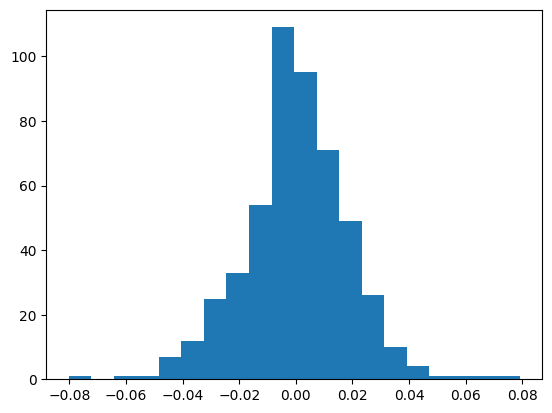

In [7]:
#Histogram of returns
plt.hist(df["returns"],bins=20)

<Axes: xlabel='Date'>

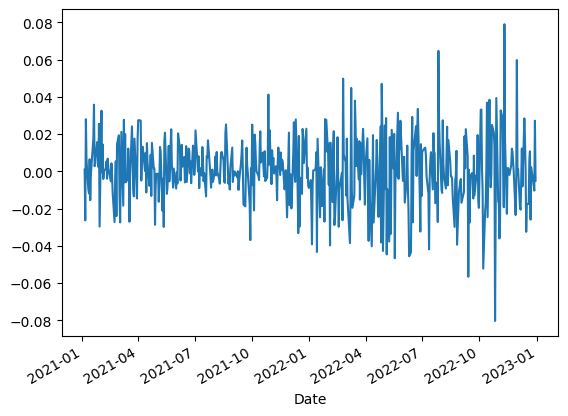

In [8]:
#Plot returns over time
df["returns"].plot()


<Axes: xlabel='Date'>

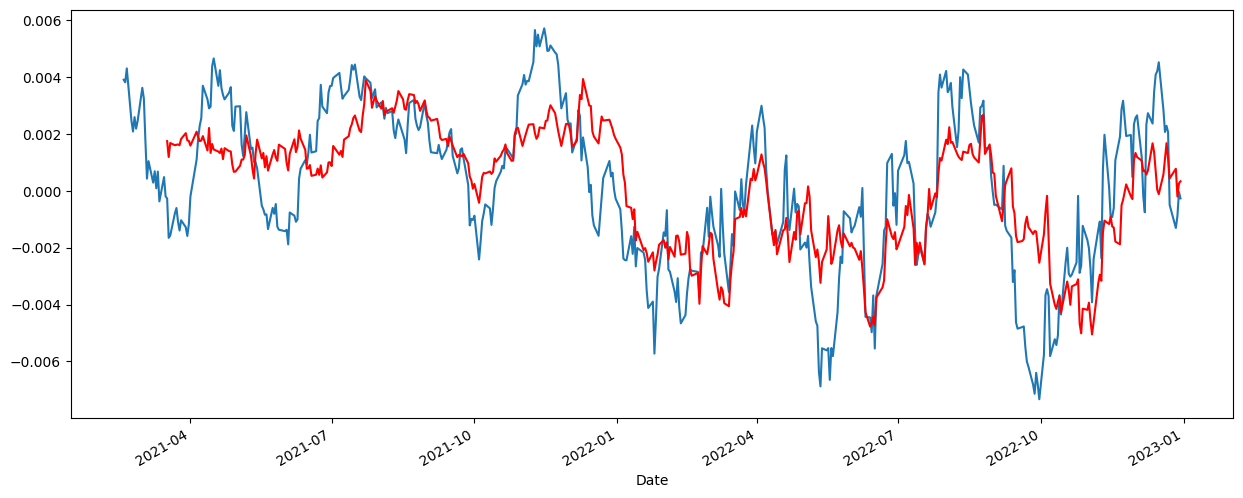

In [9]:
#Plot moving average returns 30d, 50d
fig, ax = plt.subplots(figsize=(15,6))
(df["returns"].rolling(window=30).mean().dropna()).plot()
(df["returns"].rolling(window=50).mean().dropna()).plot(color="red")


<Axes: xlabel='Date'>

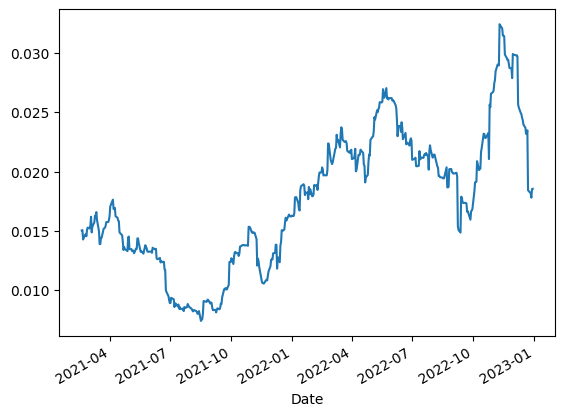

In [10]:
#Plot rolling 30d vol
(df["returns"].rolling(window=30).std().dropna()).plot()

##Chapter 3: Drawdown##

In [11]:
PORTF=100*(1+df["returns"]).cumprod()
PORTF.tail()

Date
2022-12-23    102.639627
2022-12-27    101.875804
2022-12-28    100.825675
2022-12-29    103.573669
2022-12-30    103.061008
Name: returns, dtype: float64

In [12]:
#PEAKS variable stores max value of PORTF. When PORTF grows, PEAKS updates.
PEAKS=PORTF.cummax()
PEAKS.head(20)

Date
2021-01-05    100.096416
2021-01-06    100.096416
2021-01-07    100.201625
2021-01-08    100.810290
2021-01-11    100.810290
2021-01-12    100.810290
2021-01-13    100.810290
2021-01-14    100.810290
2021-01-15    100.810290
2021-01-19    100.810290
2021-01-20    102.869413
2021-01-21    103.157890
2021-01-22    103.606287
2021-01-25    105.234973
2021-01-26    106.510974
2021-01-27    106.771945
2021-01-28    109.501197
2021-01-29    109.501197
2021-02-01    109.724941
2021-02-02    109.724941
Name: returns, dtype: float64

<Axes: xlabel='Date'>

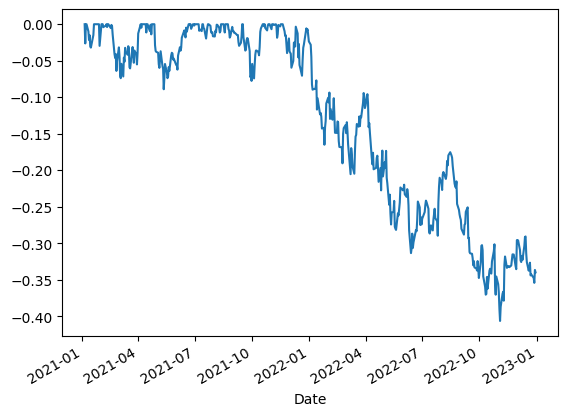

In [13]:
DRAWDOWN=(PORTF-PEAKS)/PEAKS
DRAWDOWN.plot(kind="line")

In [14]:
DRAWDOWN["2022":].min()

-0.4061004890597193

In [15]:
#When?
DRAWDOWN["2022":].idxmin()

Timestamp('2022-11-03 00:00:00')

In [16]:
#We use .ewm() method with smoothing parameter alpha=0.95
stock_ewm_vol=df["returns"].ewm(alpha=0.95).std()

In [17]:
#Annualized EWMA vola
stock_ewm_vol.mean()*np.sqrt(252)

0.2311467546619734

<Axes: xlabel='Date'>

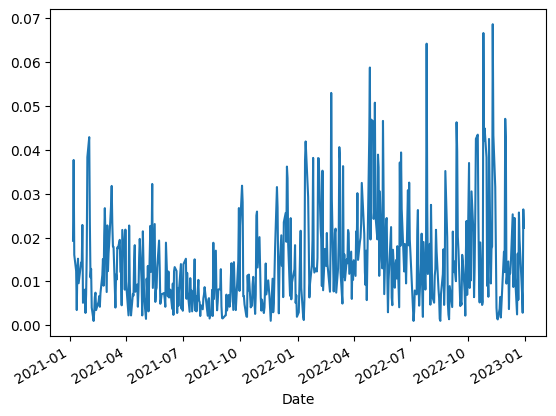

In [18]:
stock_ewm_vol.plot()

##Chapter 4: GARCH(1,1)##

In [19]:
#Part 4: Time series analysis: GARCH
!pip install arch
from arch import arch_model
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 918.2/918.2 kB 15.9 MB/s eta 0:00:00


<Axes: xlabel='Date'>

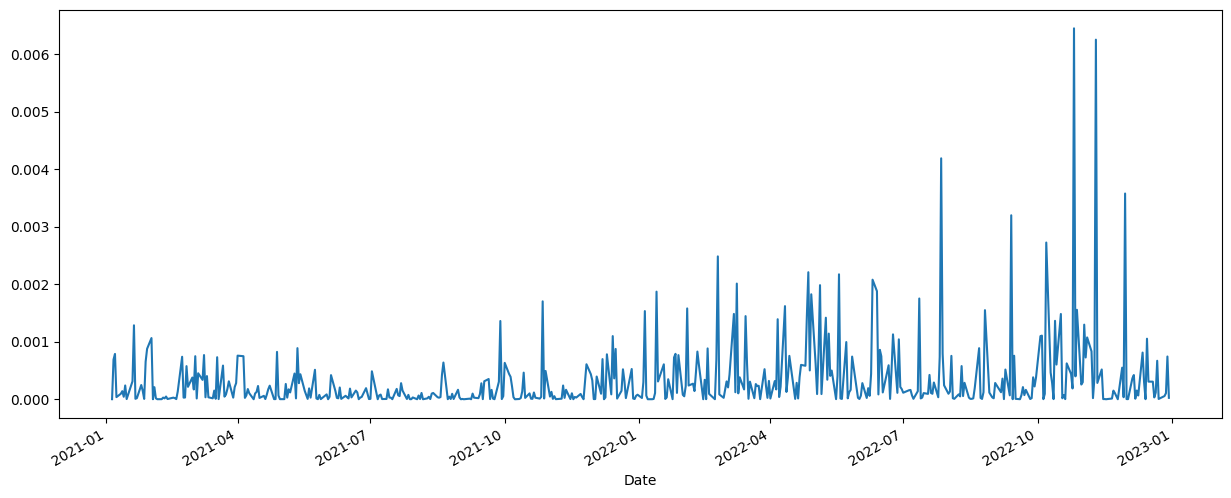

In [20]:
#Plot squared returns
fig,ax=plt.subplots(figsize=(15,6))
(df["returns"]**2).plot(ax=ax)

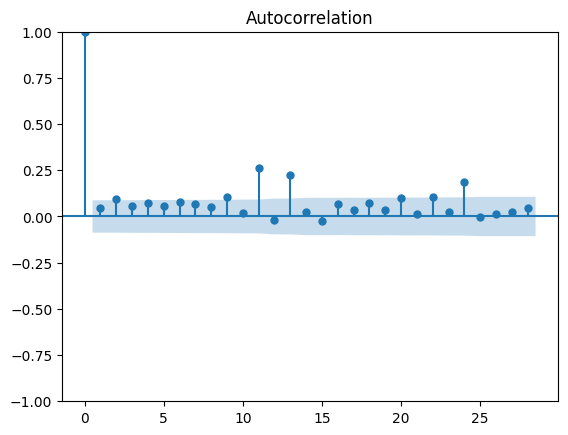

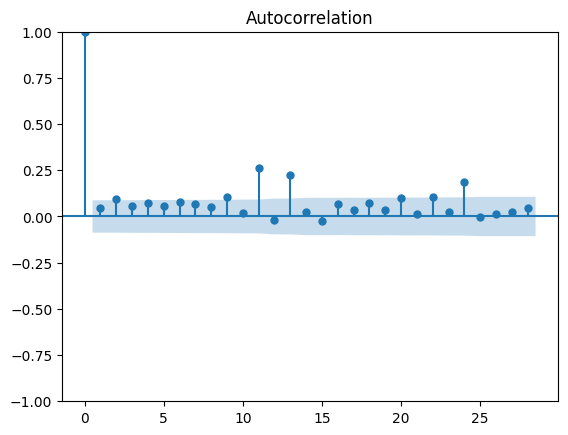

In [21]:
#plot ACF
plot_acf(df["returns"]**2)

/usr/local/lib/python3.10/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


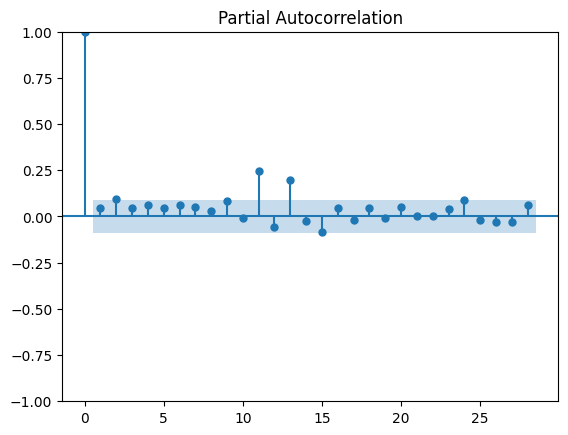

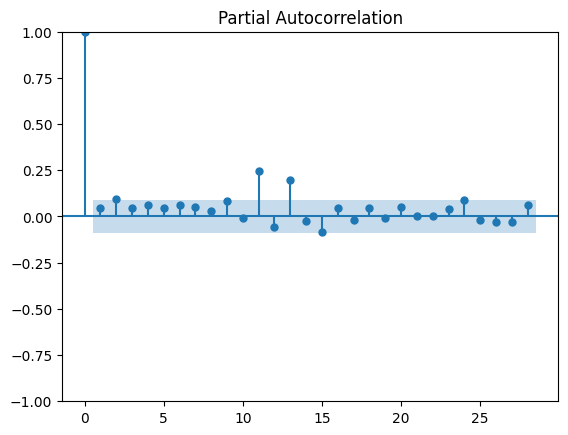

In [22]:
#plot PACF
plot_pacf(df["returns"]**2)

In [23]:
#Split data into train and test
cutoff=int(len(df["returns"])*0.8)
df_train=df["returns"].iloc[:cutoff]
df_train.shape

(401,)

In [24]:
#Train GARCH(1,1)
# sigma^2=omega(LR variance)+alpha*returns^2+beta*(previous period sigma^2)
model=arch_model(df_train,p=1,q=1,rescale=False).fit(disp=0)

In [25]:
#Check model summary
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                1087.34
Distribution:                  Normal   AIC:                          -2166.68
Method:            Maximum Likelihood   BIC:                          -2150.71
                                        No. Observations:                  401
Date:                Sun, May 14 2023   Df Residuals:                      400
Time:                        13:52:17   Df Model:                            1
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu         1.3551e-03  9.135e-05     14.833  8.901e-50 [1.176e-03,1.534e-03]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      5.7855e-06  3.026e-10  1.912e+04      0.000 [5.785e-06,5.786e-06]
alpha[1]       0.0548  1.246e-02      4.402  1.072e-05 [3.042e-02,7.925e-02]
beta[1]        0.9253  1.292e-02     71.622      0.000     [  0.900,  0.951]
============================================================================

Covariance estimator: robust
"""

<Axes: xlabel='Date'>

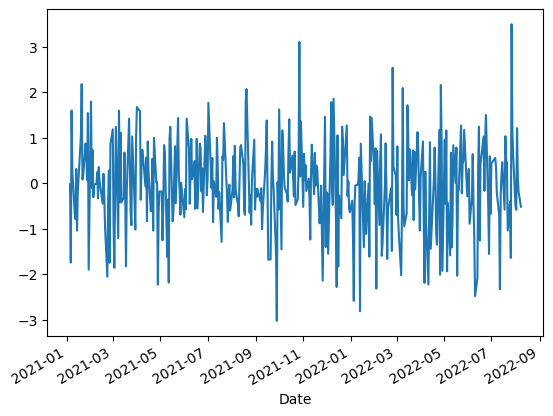

In [26]:
#Plot model residuals
model.std_resid.plot()

(array([ 2.,  1.,  4., 10.,  8., 12., 13., 11., 25., 45., 51., 51., 32.,
        30., 37., 26., 17., 12.,  7.,  4.,  0.,  1.,  0.,  1.,  1.]),
 array([-3.0227295 , -2.76215995, -2.50159039, -2.24102084, -1.98045128,
        -1.71988173, -1.45931217, -1.19874262, -0.93817306, -0.67760351,
        -0.41703395, -0.1564644 ,  0.10410515,  0.36467471,  0.62524426,
         0.88581382,  1.14638337,  1.40695293,  1.66752248,  1.92809204,
         2.18866159,  2.44923115,  2.7098007 ,  2.97037026,  3.23093981,
         3.49150936]),
 <BarContainer object of 25 artists>)

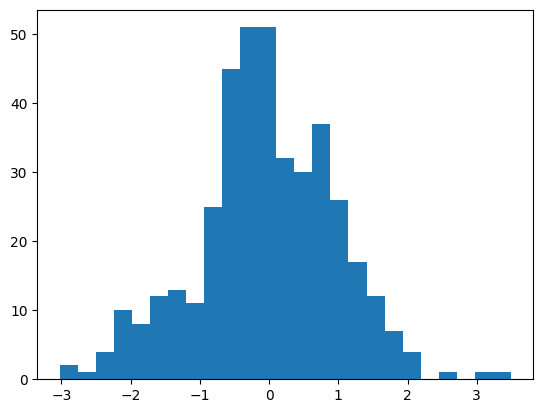

In [27]:
#Plot hist of model residuals
plt.hist(model.std_resid, bins=25)

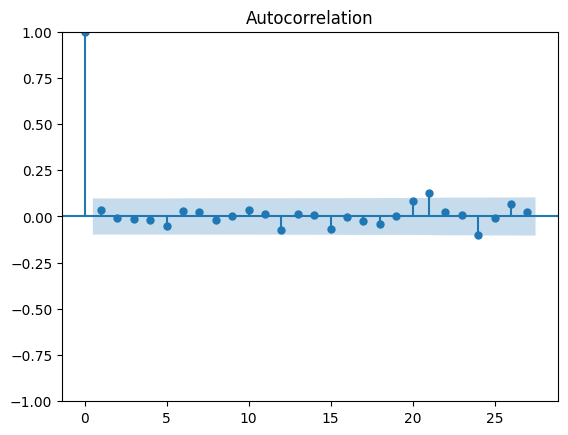

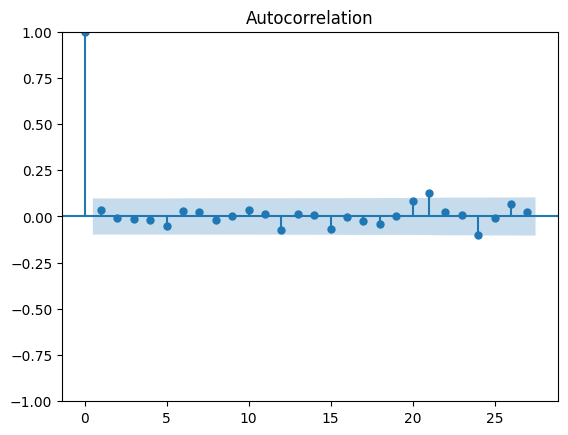

In [28]:
#Plot acf
plot_acf(model.std_resid**2)

In [29]:
#One-day forecast
garch_forecast=model.forecast(horizon=1,reindex=False).variance
garch_forecast.iloc[0,0]**0.5

0.01996933132072933

In [30]:
#Validation: walk-forward
predictions=[]
test_size=int(len(df["returns"])*0.2)
df_test_data=df["returns"].iloc[test_size:]
test_size

100

In [31]:
#Walk-forward forecasts
for i in range(test_size):
  df_train=df["returns"].iloc[:-(test_size-i)]
  model=arch_model(df_train,p=1,q=1,rescale=False).fit(disp=0)
  next_pred=model.forecast(horizon=1,reindex=False).variance.iloc[0,0]**0.5
  predictions.append(next_pred)
len(predictions)

100

In [32]:
df_test_wfv=pd.Series(predictions,index=df.tail(test_size).index)
df_test_wfv.head()

Date
2022-08-10    0.019421
2022-08-11    0.019553
2022-08-12    0.019108
2022-08-15    0.018902
2022-08-16    0.018400
dtype: float64

<Axes: xlabel='Date'>

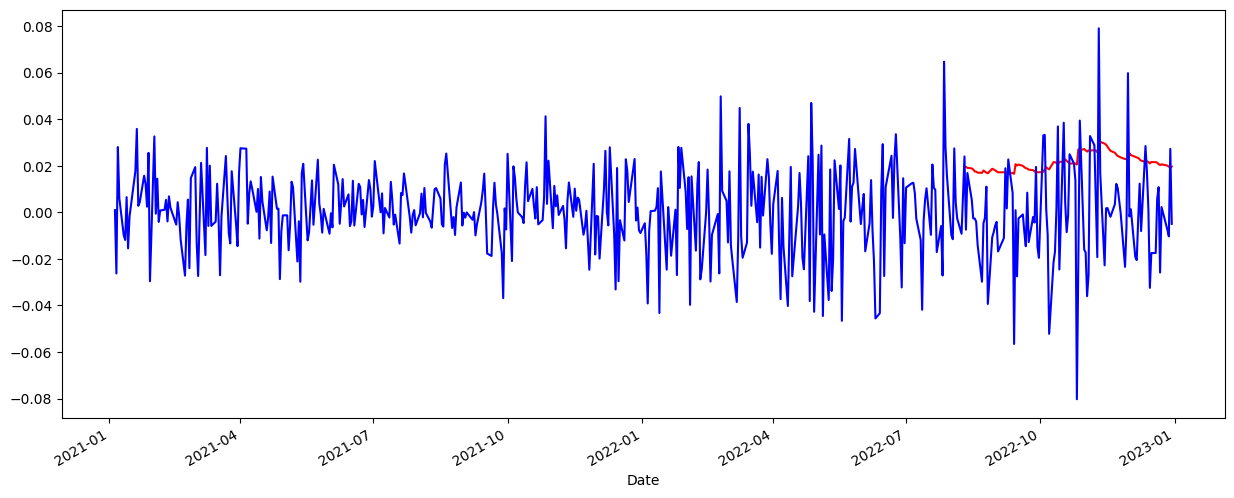

In [33]:
#Plot wf forecasts vs actual
fig, ax = plt.subplots(figsize=(15,6))
df_test_wfv.plot(color="red")
df["returns"].plot(color="blue")